In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import copy
import healpy as hp
import lsst.sims.maf.metricBundles as metricBundles
repoDir= os.getcwd()
os.chdir(os.path.join(repoDir , '..' ))
repoDir= os.getcwd()
from intermediates import *
from plotFunctions import *

In [2]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz', 
             'coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''

    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for RandomDitherFieldPerVisit:  coaddM5Data_masked_r_RandomDitherFieldPerVisit.npz



### Read in OpSim data.

In [3]:
dbpath = path+'minion_1016_sqlite_new_dithers.db'   # new afterburner output
extraCols= ['expDate', 'obsHistID','ditheredRotTelPos', 'rotTelPos']
simdata= getSimData(dbpath, 'r', extraCols= extraCols, newAfterburner= True)

In [4]:
pixelNum= getSurveyHEALPixRADec(coaddBundle)   # each output is a dicitonary.

In [5]:
pixels_in_FOV= getFOVsHEALPixReln(pixelNum, simdata, nside= 256) # each output is a dicitonary.

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Number of fieldIDs in pixel_in_FOV for RandomDitherFieldPerVisit: 2250


FOV centers are given by pointingRA, pointingDec

Take that Ra, Dec; convert to HEALPix pixel; plot.

In [6]:
# fieldID we know are in the region of interest
allIDs= [1568, 1220,  1413, 1542, 1447, 1564, 1323, 1234, 1333, 1431, 1464, 1305, 1212, 1365]

In [7]:
pointingPixels= {}   # find the HEALPix pixel that corresponds to the center of each FOV.

for dith in coaddBundle:
    if dith not in pointingPixels.keys():
        pointingPixels[dith]= {}
    for ID in allIDs:  # loop over all IDs in the region
        if ID not in pointingPixels[dith].keys():
            pointingPixels[dith][ID]= []
        ind= np.where(simdata['fieldID']==ID)[0]

        for i in ind:  # loop over all obs related to the ID
            if (dith=='NoDither'):
                ra, dec= simdata['fieldRA'][i], simdata['fieldDec'][i]
            elif (dith== 'RandomDitherFieldPerVisit'):
                ra, dec= simdata['randomDitherFieldPerVisitRA'][i], simdata['randomDitherFieldPerVisitDec'][i]
            lat= np.pi/2. - dec
            pix = hp.ang2pix(nside= 256, theta= lat, phi= ra)
            pointingPixels[dith][ID].append(pix)
        pointingPixels[dith][ID]= np.unique(pointingPixels[dith][ID])

In [8]:
# check
pointingPixels['NoDither'][1212]

array([606982])

In [9]:
# find the pixels in the region.
centralRA, centralDec, regionPixels= findRegionPixels(1447, simdata,
                                                          nside= 256,
                                                          disc= False, FOV_radius= 0.0305)

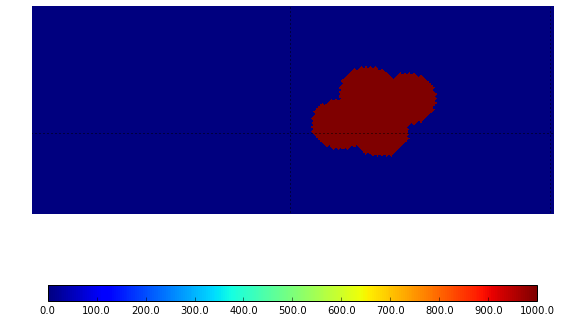

In [10]:
# plot region
raRange= [np.degrees(ra)-20,np.degrees(ra)+20]
decRange= [np.degrees(dec)-8,np.degrees(dec)+8]

check= copy.deepcopy(coaddBundle['NoDither'])
check.metricValues.data[:]= 0
check.metricValues.data[regionPixels]= 1000   # artificial data
# plot the FOV
plt.clf()
hp.cartview(check.metricValues.filled(check.slicer.badval), 
            flip='astro', rot=(0,0,0) ,
            lonra= raRange, latra= decRange,
            title= '', cbar=False)
hp.graticule(dpar=20, dmer=20, verbose=False)
ax = plt.gca()
im = ax.get_images()[0]
fig= plt.gcf()
cbaxes = fig.add_axes([0.1, 0.01, 0.8, 0.04]) # [left, bottom, width, height]
cb = plt.colorbar(im,  orientation='horizontal',
                  format= '%.1f', cax = cbaxes) 
plt.show()

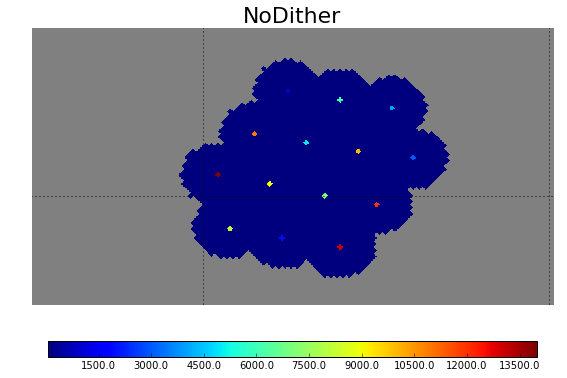

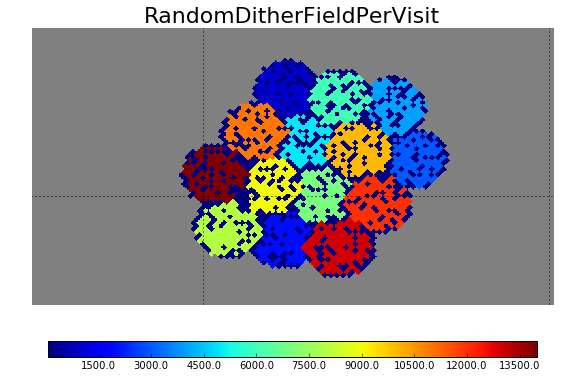

In [11]:
raRange= [np.degrees(ra)-20,np.degrees(ra)+10]
decRange= [np.degrees(dec)-8,np.degrees(dec)+8]

for dither in coaddBundle:
    check= copy.deepcopy(coaddBundle[dither])
    check.metricValues.mask[:]= True
    check.metricValues.data[regionPixels]= 500   # artificial data
    for i, fID in enumerate(allIDs): #enumerate([1447, 1323, 1431, 1333]): 
        check.metricValues.mask[pixels_in_FOV[dither][fID]]= False   # artificial data
        check.metricValues.data[pixels_in_FOV[dither][fID]]= 50   # artificial data
        check.metricValues.data[pointingPixels[dither][fID]]=  1000*(i+1)   # artificial data
        
    # plot the FOV
    plt.clf()
    hp.cartview(check.metricValues.filled(check.slicer.badval), 
                flip='astro', rot=(0,0,0) ,
                lonra= raRange, latra= decRange,
                
                min= 50,
                #min= 50, max= 50000,
                title= '', cbar=False)
    hp.graticule(dpar=20, dmer=20, verbose=False)
    plt.title('%s'%(dither), size= 22)
    ax = plt.gca()
    im = ax.get_images()[0]
    fig= plt.gcf()
    cbaxes = fig.add_axes([0.1, 0.01, 0.8, 0.04]) # [left, bottom, width, height]
    cb = plt.colorbar(im,  orientation='horizontal',
                      format= '%.1f', cax = cbaxes) 
    plt.show()

Ok so the dithers are working.

Now plot each fieldID with its pointings, overlap with the region, etc.

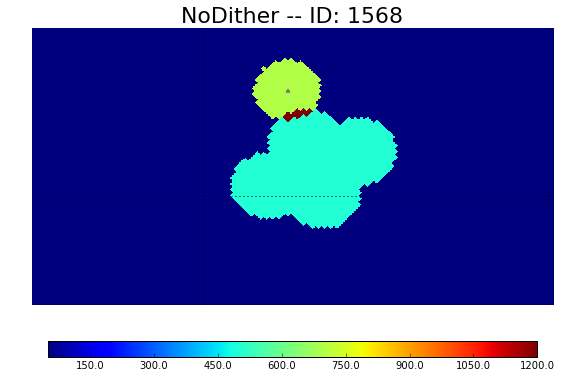

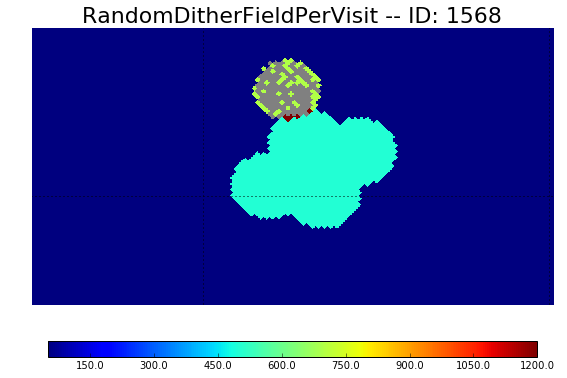

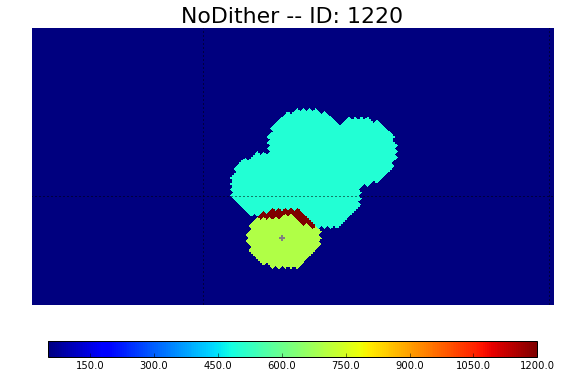

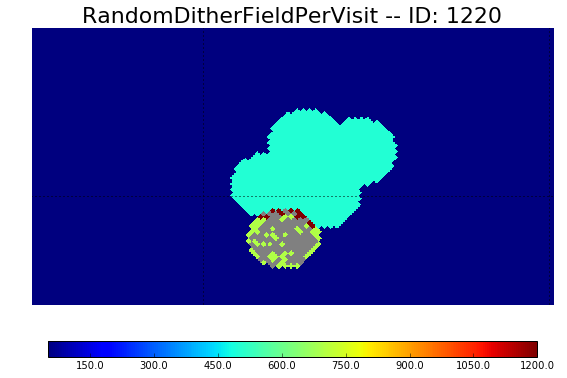

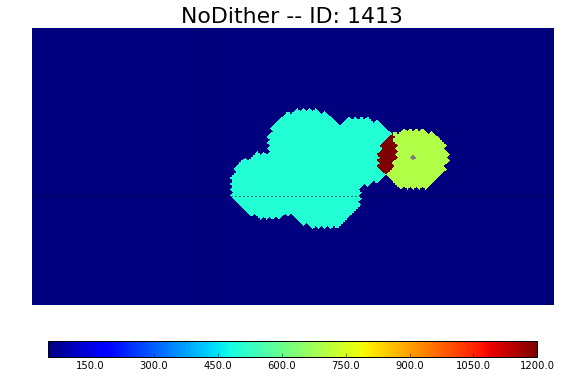

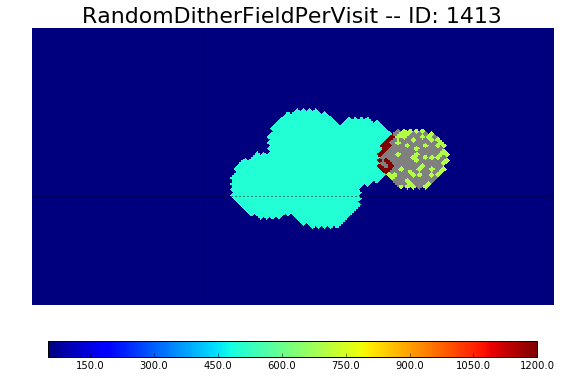

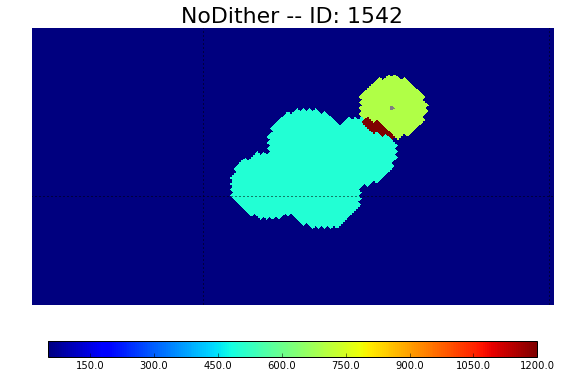

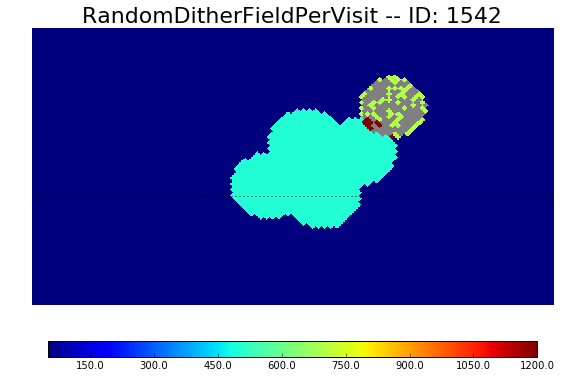

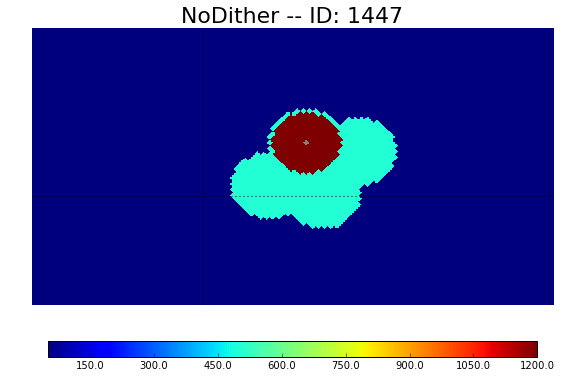

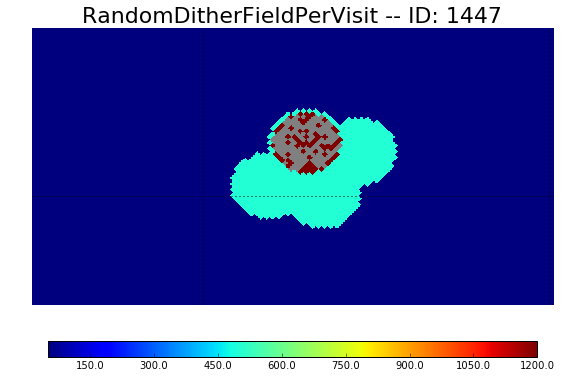

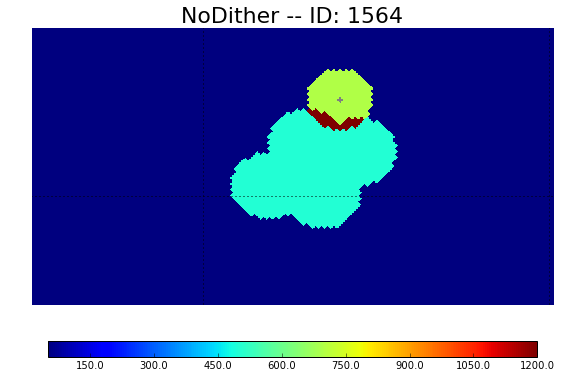

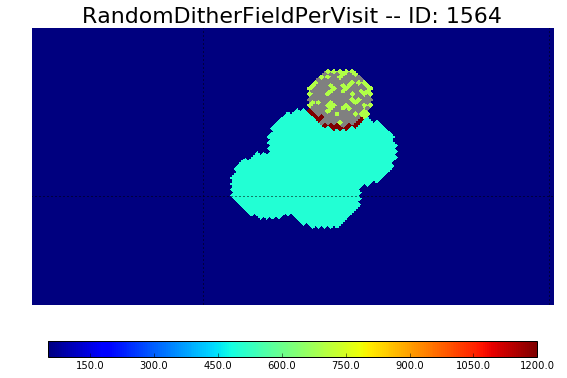

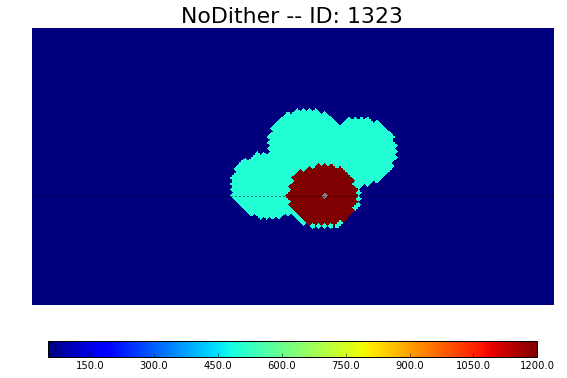

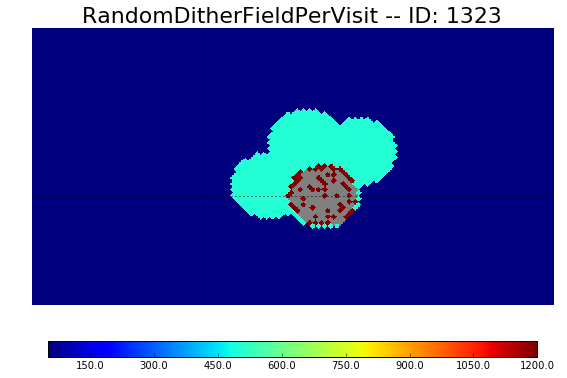

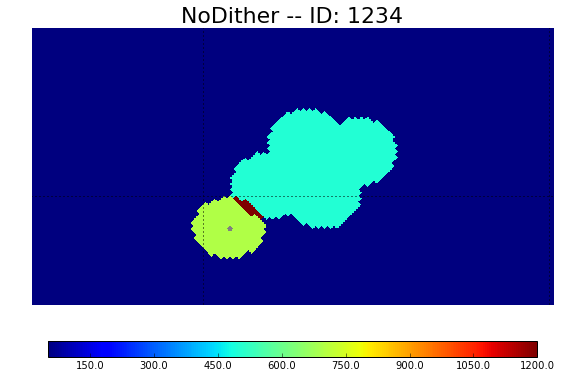

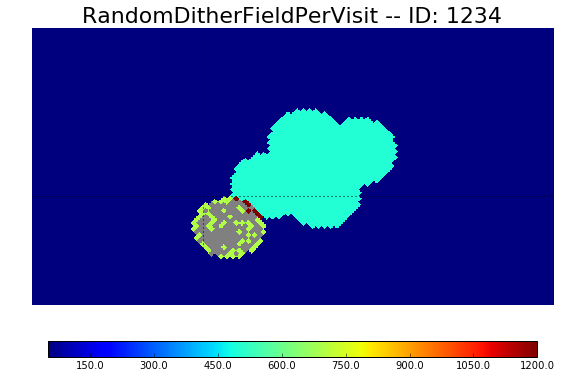

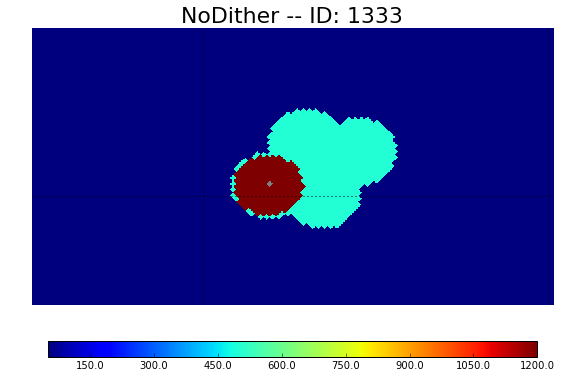

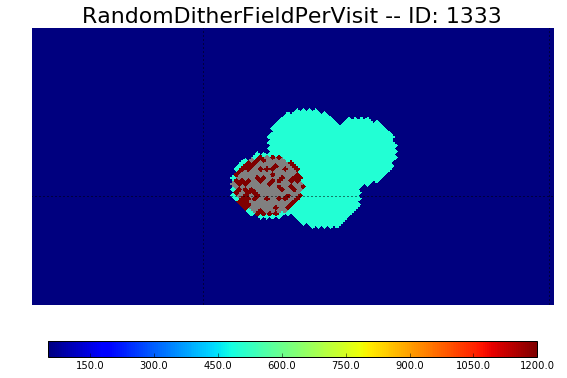

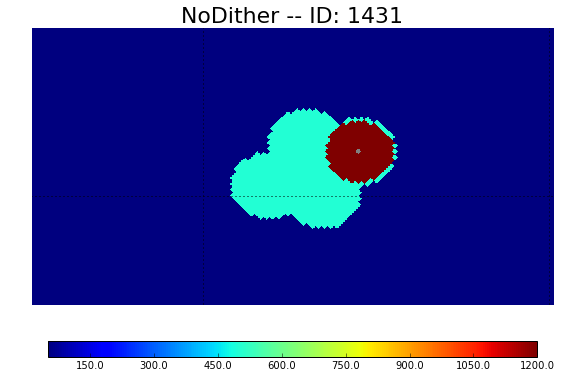

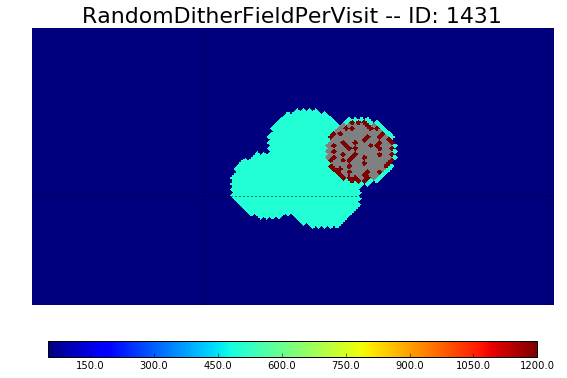

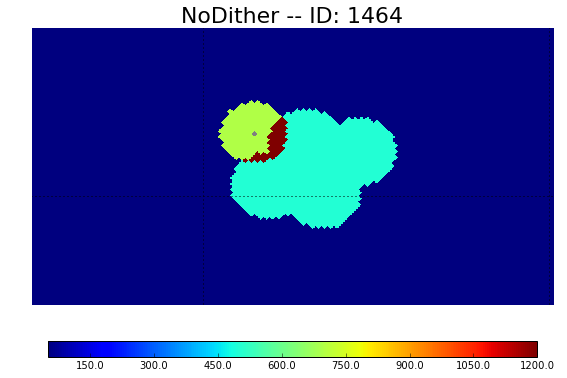

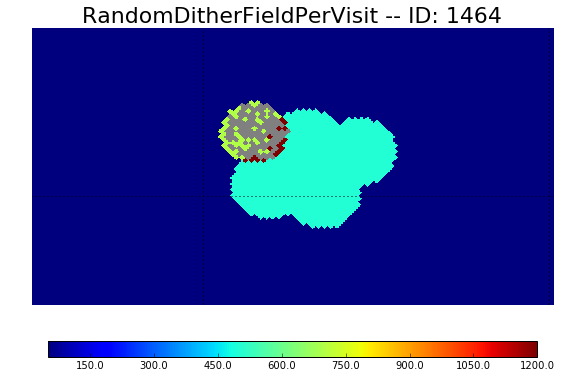

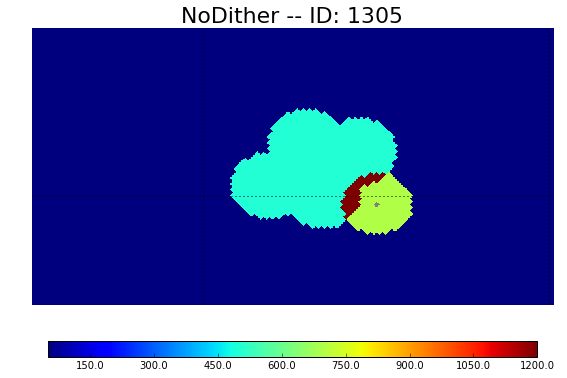

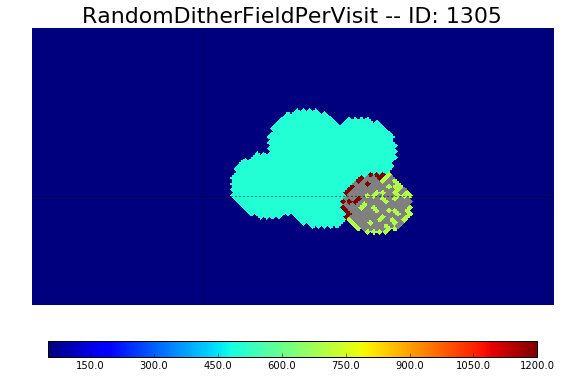

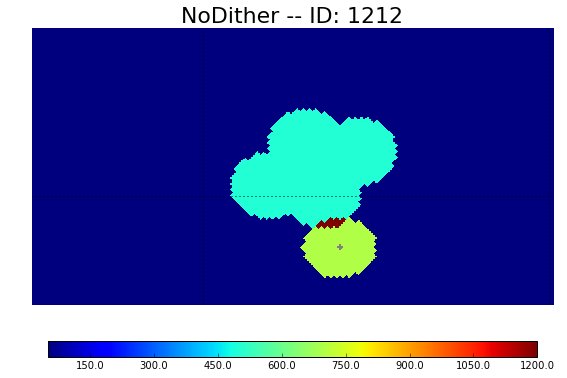

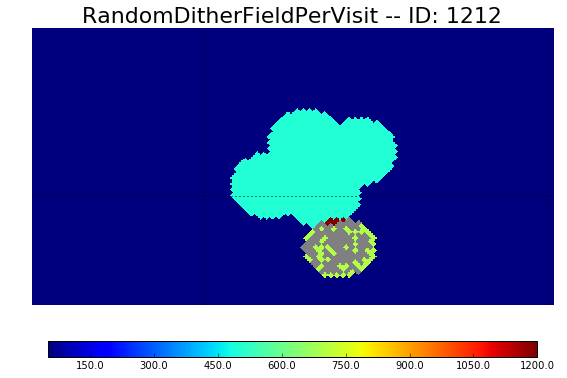

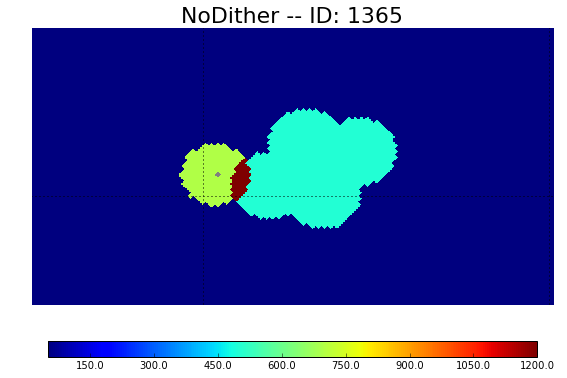

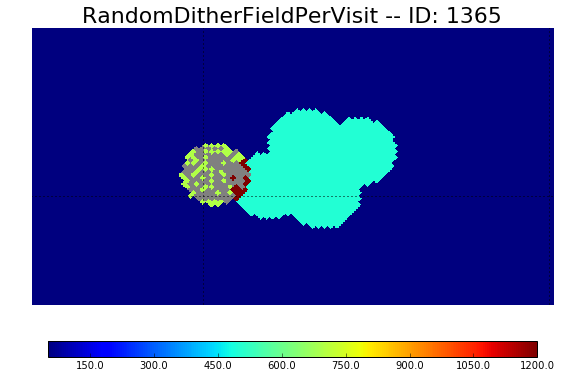

In [12]:
raRange= [np.degrees(ra)-20,np.degrees(ra)+10]
decRange= [np.degrees(dec)-8,np.degrees(dec)+8]
    
for i, fID in enumerate(allIDs): # loop over specified fieldIDs
    for dither in coaddBundle:
        check= copy.deepcopy(coaddBundle[dither])
        check.metricValues.data[:]= 0
        check.metricValues.data[regionPixels]+= 500   # artificial data
        check.metricValues.data[pixels_in_FOV[dither][fID]]+= 700   # artificial data
        check.metricValues.mask[pointingPixels[dither][fID]]= True   # artificial data
        # plot the FOV
        plt.clf()
        hp.cartview(check.metricValues.filled(check.slicer.badval), 
                    flip='astro', rot=(0,0,0) ,
                    lonra= raRange, latra= decRange,
                    min= 50,
                    #min= 50, max= 50000,
                    title= '', cbar=False)
        hp.graticule(dpar=20, dmer=20, verbose=False)
        plt.title('%s -- ID: %s'%(dither, fID), size= 22)
        ax = plt.gca()
        im = ax.get_images()[0]
        fig= plt.gcf()
        cbaxes = fig.add_axes([0.1, 0.01, 0.8, 0.04]) # [left, bottom, width, height]
        cb = plt.colorbar(im,  orientation='horizontal',
                          format= '%.1f', cax = cbaxes) 
        plt.show()

In [13]:
# read in the pickle data to see whats up with the chips
import pickle

filenames= [f for f in os.listdir(repoDir+'/chipsPerVisitData/') if any([f.endswith('pickle')])]
pickleData= {}

for filename in filenames:
    splits= filename.split('_')
    if (len(splits)==8):
        key= splits[4]+'_'+splits[5]
    else:
        key= splits[4]
    with open(repoDir+'/chipsPerVisitData/'+filename, 'rb') as handle:
        pickleData[key]= pickle.load(handle)

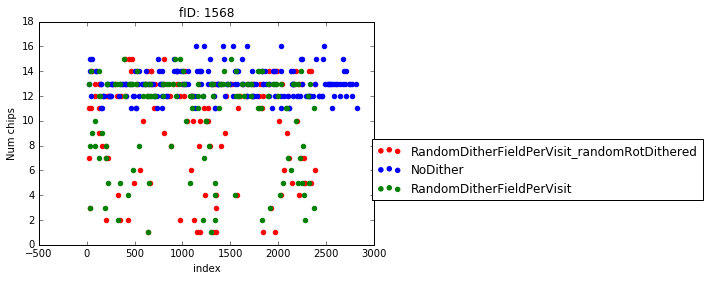

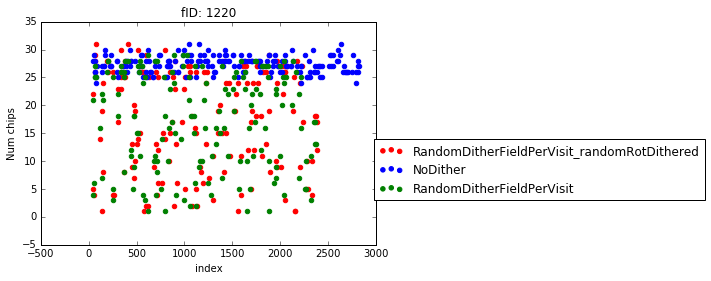

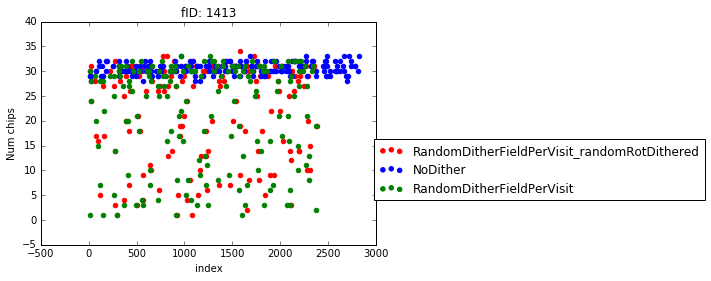

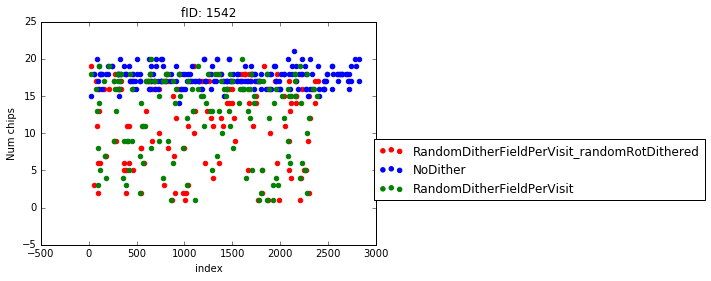

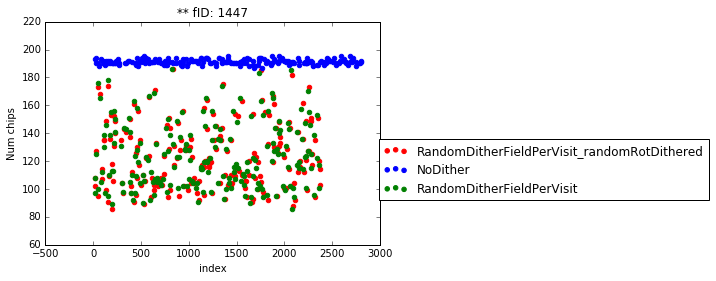

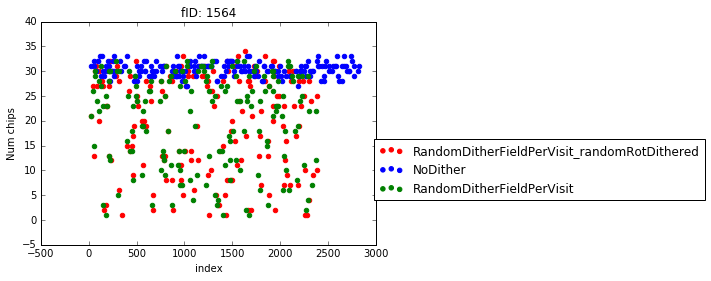

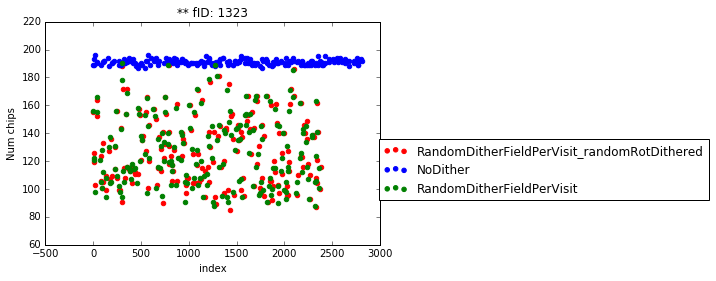

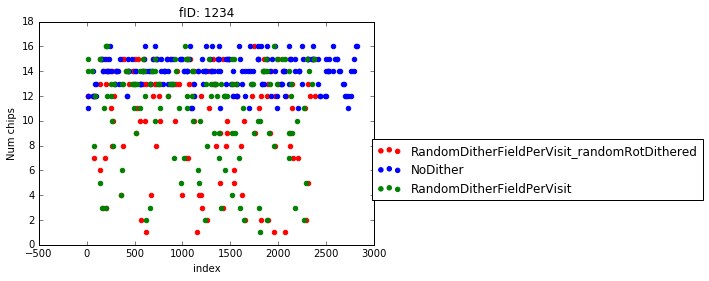

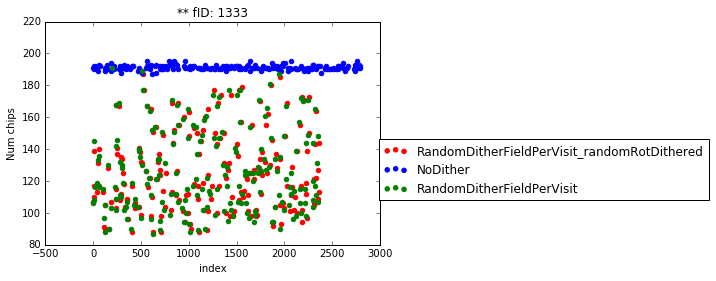

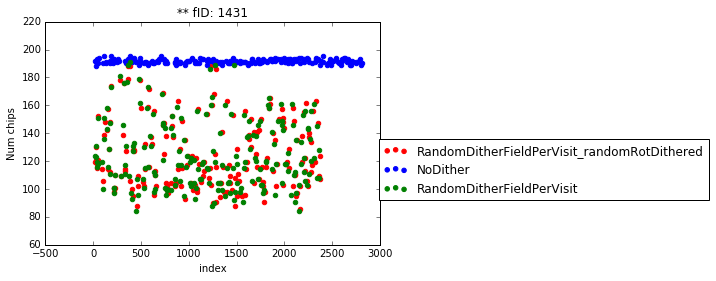

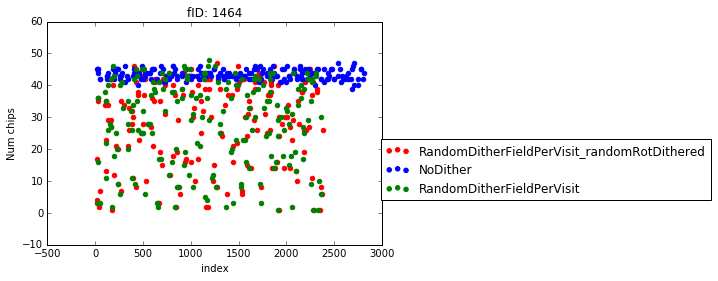

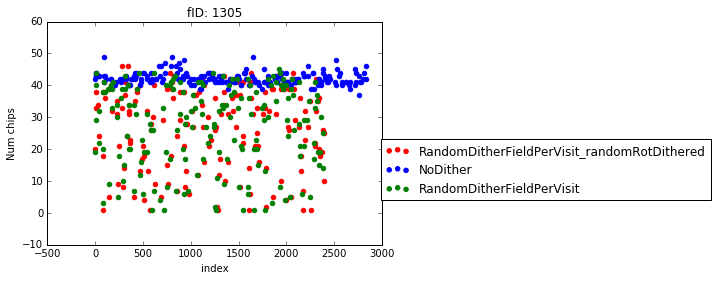

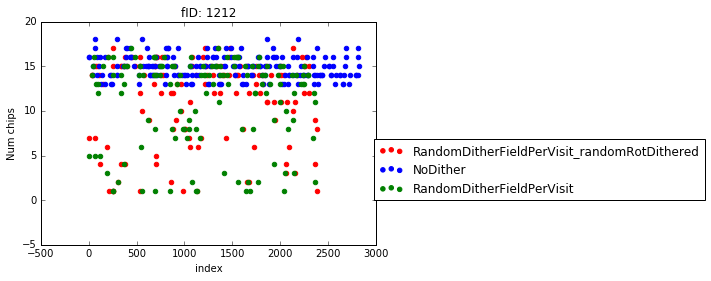

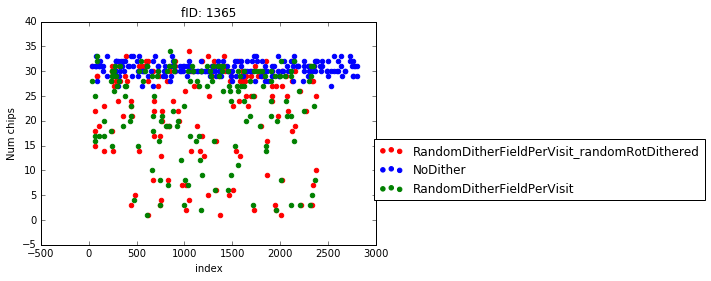

In [73]:
color= ['r', 'b', 'g']
for fID in allIDs:
    plt.clf()
    for j, dither in enumerate(pickleData):
        okie= 0
        
        for i,ID in enumerate(pickleData[dither]['fIDs']):
            if (ID==fID):
                if (okie==0):  # put legend on the first run only
                    plt.scatter(i,len(pickleData[dither]['chipNames'][i]), label= dither, color= color[j])
                else:
                    plt.scatter(i,len(pickleData[dither]['chipNames'][i]), color= color[j])
                okie+=1
                
    if fID in [1447, 1323, 1431, 1333]:   # 4 contiguous unditheresd fields
        plt.title('** fID: %s'%(fID))
    else:
        plt.title('fID: %s'%(fID))
    plt.xlabel('index')
    plt.ylabel('Num chips')
    plt.legend(bbox_to_anchor= (2.,0.5))
    plt.show()

In [75]:
totChips= []
dither= 'RandomDitherFieldPerVisit_randomRotDithered'
for i,ID in enumerate(pickleData[dither]['fIDs']):

    if (ID==1305):
        totChips.append(len(pickleData[dither]['chipNames'][i]))


In [77]:
max(totChips)

46

In [15]:
ind= np.where(simdata['fieldID']==1305)[0]
print np.unique(simdata['fieldRA'][ind])
print np.unique(simdata['fieldDec'][ind])
diffDec= simdata['randomDitherFieldPerVisitDec'][ind]- np.unique(simdata['fieldDec'][ind][0])
diffRA= simdata['randomDitherFieldPerVisitRA'][ind]- np.unique(simdata['fieldRA'][ind][0])

diffx= diffRA*np.cos(simdata['fieldDec'][ind][0])

dith_magnitude= np.sqrt(diffx**2+diffDec**2)

[ 1.570014]
[-0.531501]


In [16]:
threeLargest_ind= dith_magnitude.argsort()[-3:][::-1]

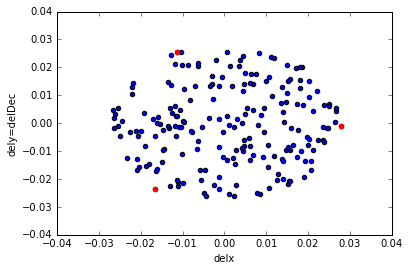

In [17]:
plt.scatter(diffx, diffDec)
plt.scatter(diffx[threeLargest_ind], diffDec[threeLargest_ind], color='r')
plt.xlabel('delx')
plt.ylabel('dely=delDec')

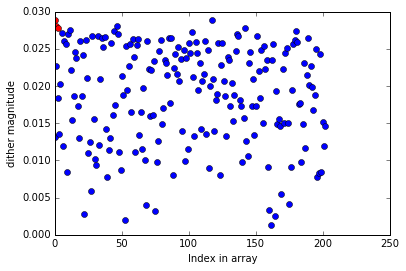

In [19]:
plt.plot(dith_magnitude, 'o')
plt.plot(dith_magnitude[threeLargest_ind], 'o', color='r')
plt.xlabel('Index in array')
plt.ylabel('dither magnitude')

In [20]:
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.utils import ObservationMetaData
from lsst.sims.coordUtils import chipNameFromRaDec
import lsst.sims.maf.slicers as slicers
camera = LsstSimMapper().camera

In [21]:
nside= 256
hpSlicer= slicers.HealpixSlicer(nside= nside)
hpSlicer.setupSlicer(simdata)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


Index:  117
Pointing RA, Dec:  1.55089323931 -0.55513
Pixel number containing the pointing RA, Dec:  599804
Pixel RA, Dec:  1.54932059576 -0.553939478867


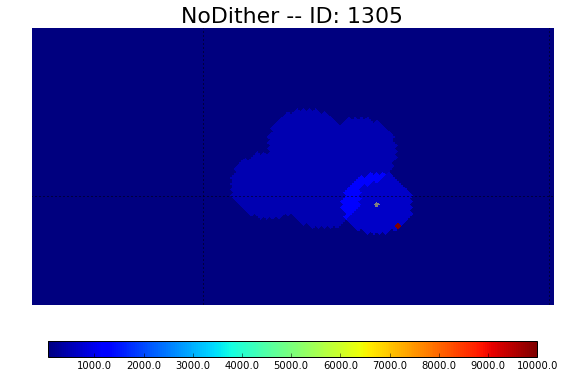


Index:  46
Pointing RA, Dec:  1.55696483195 -0.50582
Pixel number containing the pointing RA, Dec:  583421
Pixel RA, Dec:  1.55545651892 -0.505648626651


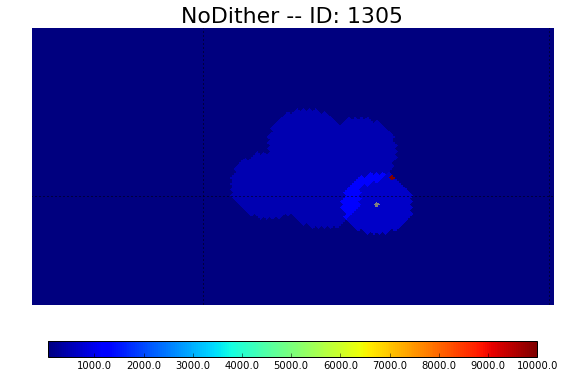


Index:  142
Pointing RA, Dec:  1.60226745084 -0.532514
Pixel number containing the pointing RA, Dec:  592645
Pixel RA, Dec:  1.60147594255 -0.532643612966


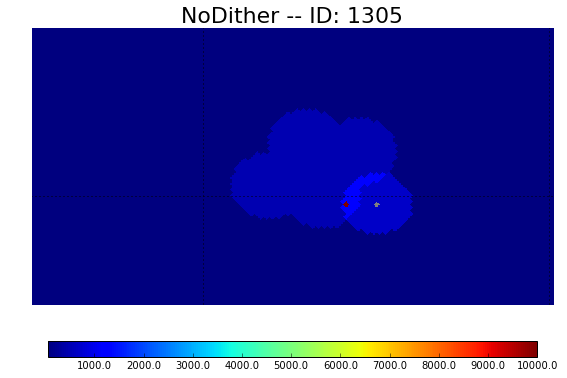

In [22]:
# loop over largest dithers:
for index in threeLargest_ind:
    print 'Index: ', index
    pointingRA= simdata['randomDitherFieldPerVisitRA'][ind][index]  # poiting RA
    pointingDec= simdata['randomDitherFieldPerVisitDec'][ind][index]   # pointin Dec
    rotSkyPos= simdata['rotSkyPos'][ind][index]
    expMJD= simdata['expMJD'][ind][index]
    obsHistID= simdata['obsHistID'][ind][index]

    print 'Pointing RA, Dec: ', pointingRA, pointingDec
    
    lat= np.pi/2. - pointingDec
    pix = hp.ang2pix(nside= nside, theta= lat, phi= pointingRA)
    print 'Pixel number containing the pointing RA, Dec: ', pix
    pixRA, pixDec= hpSlicer._pix2radec(pix) 

    print 'Pixel RA, Dec: ',pixRA, pixDec
    
    
    raRange= [np.degrees(ra)-20,np.degrees(ra)+10]
    decRange= [np.degrees(dec)-8,np.degrees(dec)+8]

    for i, fID in enumerate([1305]): # loop over specified fieldIDs
        for dither in ['NoDither']:
            check= copy.deepcopy(coaddBundle[dither])
            check.metricValues.data[:]= 0
            check.metricValues.data[regionPixels]+= 500   # artificial data
            check.metricValues.data[pixels_in_FOV[dither][fID]]+= 700   # artificial data
            check.metricValues.mask[pointingPixels[dither][fID]]= True   # artificial data
            check.metricValues.mask[pix]= False
            check.metricValues.data[pix]= 10000

            # plot the FOV
            plt.clf()
            hp.cartview(check.metricValues.filled(check.slicer.badval), 
                        flip='astro', rot=(0,0,0) ,
                        lonra= raRange, latra= decRange,
                        min= 50,
                        #min= 50, max= 50000,
                        title= '', cbar=False)
            hp.graticule(dpar=20, dmer=20, verbose=False)
            plt.title('%s -- ID: %s'%(dither, fID), size= 22)
            ax = plt.gca()
            im = ax.get_images()[0]
            fig= plt.gcf()
            cbaxes = fig.add_axes([0.1, 0.01, 0.8, 0.04]) # [left, bottom, width, height]
            cb = plt.colorbar(im,  orientation='horizontal',
                              format= '%.1f', cax = cbaxes) 
            plt.show()
        
    print ''

Ok so we care about the dither corresponding to Index 42. Run the chios analysis here.

In [23]:
index= 42
pointingRA= simdata['randomDitherFieldPerVisitRA'][ind][index]  # poiting RA
pointingDec= simdata['randomDitherFieldPerVisitDec'][ind][index]   # pointin Dec
rotSkyPos= simdata['rotSkyPos'][ind][index]
expMJD= simdata['expMJD'][ind][index]
obsHistID= simdata['obsHistID'][ind][index]

print 'Pointing RA, Dec: ', pointingRA, pointingDec


lat= np.pi/2. - pointingDec
pix = hp.ang2pix(nside= nside, theta= lat, phi= pointingRA)
print 'Pixel number containing the pointing RA, Dec: ', pix
pixRA, pixDec= hpSlicer._pix2radec(pix) 

print 'Pixel RA, Dec: ',pixRA, pixDec

Pointing RA, Dec:  1.58797473153 -0.55216
Pixel number containing the pointing RA, Dec:  598787
Pixel RA, Dec:  1.58920409625 -0.550880295719


In [24]:
obs = ObservationMetaData(pointingRA= np.degrees(pointingRA), pointingDec= np.degrees(pointingDec),
                                      rotSkyPos= np.degrees(rotSkyPos), mjd= expMJD)
print chipNameFromRaDec(np.degrees(pixRA), np.degrees(pixDec),
                                            camera=camera, obs_metadata=obs)

R:2,2 S:1,1


/Users/Humna/lsst/DarwinX86/sims_utils/12.0-13-g6534730/python/lsst/sims/utils/ModifiedJulianDate.py:188: UTCtoUT1Warning: UTC is outside of IERS table for UT1-UTC.
Returning UT1 = UTC for lack of a better idea
This warning was caused by calling ModifiedJulianDate.dut1

  category=UTCtoUT1Warning)


get something. so the rourtine is working.

In [83]:
# run the chip analysis -- here at a lower nside than in the DC1 repo. Also not accounting for rotational dithers.
numChips= []
for p, pixel in enumerate(regionPixels):  # run over all the pixels in the region
    pixRA, pixDec= hpSlicer._pix2radec(pixel)    # radians returned
    indObsInPixel = hpSlicer._sliceSimData(pixel)   # indices in simData for when an observation
                                                 # happened in this pixel
    for index in indObsInPixel['idxs']:
        obsID= simdata[index]['obsHistID']
        fID= simdata[index]['fieldID']

    
        if (fID==1305):
            pointingRA= simdata[index]['randomDitherFieldPerVisitRA'] # radians
            pointingDec= simdata[index]['randomDitherFieldPerVisitDec'] # radians
            rotSkyPos= simdata[index]['rotSkyPos'] # radians
            expMJD= simdata[index]['expMJD']

            # set up for the finding the chips
            obs = ObservationMetaData(pointingRA= np.degrees(pointingRA), pointingDec= np.degrees(pointingDec),
                                      rotSkyPos= np.degrees(rotSkyPos), mjd= expMJD)
            
            chips= chipNameFromRaDec(np.degrees(pixRA), np.degrees(pixDec),
                                            camera=camera, obs_metadata=obs)
            #print chips

            if chips is not None:
                numChips.append(len(chips))


In [84]:
len(numChips)

4171

In [86]:
max(numChips)

13

In [33]:
# run the chip analysis -- here at a lower nside than in the DC1 repo. NOW account for rotational dithers.
listOfChips_rotDither= []
for p, pixel in enumerate(regionPixels):  # run over all the pixels in the region
    pixRA, pixDec= hpSlicer._pix2radec(pixel)    # radians returned
    indObsInPixel = hpSlicer._sliceSimData(pixel)   # indices in simData for when an observation
                                                 # happened in this pixel
    for index in indObsInPixel['idxs']:
        obsID= simdata[index]['obsHistID']
        fID= simdata[index]['fieldID']

    
        if (fID==1305):
            pointingRA= simdata[index]['randomDitherFieldPerVisitRA'] # radians
            pointingDec= simdata[index]['randomDitherFieldPerVisitDec'] # radians
            rotSkyPos= simdata[index]['rotSkyPos'] # radians
            expMJD= simdata[index]['expMJD']

            parallacticAngle= simdata[index]['rotTelPos']-simdata[index]['rotSkyPos']
            ditheredRotSkyPos= simdata[index]['ditheredRotTelPos']-parallacticAngle
            rotSkyPos= ditheredRotSkyPos
                
                
            # set up for the finding the chips
            obs = ObservationMetaData(pointingRA= np.degrees(pointingRA), pointingDec= np.degrees(pointingDec),
                                      rotSkyPos= np.degrees(rotSkyPos), mjd= expMJD)
            listOfChips_rotDither.append([chipNameFromRaDec(np.degrees(pixRA), np.degrees(pixDec),
                                            camera=camera, obs_metadata=obs)])
            
            
            

In [37]:
counter= 0
for i in listOfChips_rotDither:
    if i[0] is not None:
        counter+=1
print counter

4173


In [38]:
np.unique(listOfChips_rotDither)

array([None, 'R:0,0 S:1,2', 'R:0,0 S:2,1', 'R:0,0 S:2,2,A',
       'R:0,0 S:2,2,B', 'R:0,1 S:0,0', 'R:0,1 S:0,1', 'R:0,1 S:0,2',
       'R:0,1 S:1,0', 'R:0,1 S:1,1', 'R:0,1 S:1,2', 'R:0,1 S:2,0',
       'R:0,1 S:2,1', 'R:0,1 S:2,2', 'R:0,2 S:0,0', 'R:0,2 S:0,1',
       'R:0,2 S:0,2', 'R:0,2 S:1,0', 'R:0,2 S:1,1', 'R:0,2 S:1,2',
       'R:0,2 S:2,0', 'R:0,2 S:2,1', 'R:0,2 S:2,2', 'R:0,3 S:0,0',
       'R:0,3 S:0,1', 'R:0,3 S:0,2', 'R:0,3 S:1,0', 'R:0,3 S:1,1',
       'R:0,3 S:1,2', 'R:0,3 S:2,0', 'R:0,3 S:2,1', 'R:0,3 S:2,2',
       'R:0,4 S:1,0', 'R:0,4 S:2,0,A', 'R:0,4 S:2,0,B', 'R:0,4 S:2,1',
       'R:1,0 S:0,0', 'R:1,0 S:0,1', 'R:1,0 S:0,2', 'R:1,0 S:1,0',
       'R:1,0 S:1,1', 'R:1,0 S:1,2', 'R:1,0 S:2,0', 'R:1,0 S:2,1',
       'R:1,0 S:2,2', 'R:1,1 S:0,0', 'R:1,1 S:0,1', 'R:1,1 S:0,2',
       'R:1,1 S:1,0', 'R:1,1 S:1,1', 'R:1,1 S:1,2', 'R:1,1 S:2,0',
       'R:1,1 S:2,1', 'R:1,1 S:2,2', 'R:1,2 S:0,0', 'R:1,2 S:0,1',
       'R:1,2 S:0,2', 'R:1,2 S:1,0', 'R:1,2 S:1,1', 'R:1,2 S:1,

In [39]:
len(np.unique(listOfChips_rotDither))

206

So rotational dithers dont appear to be causing the problem.